In [1]:
import pandas as pd
import numpy as np
import gc

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import LabelEncoder

import datetime as dt

from collections import Counter
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/kaggle/input/my-metu-data/'

train_df = pd.read_csv(path+'train.csv',  parse_dates=['JobStartDate', 'JobCreateDate'])
test_df = pd.read_csv(path+'test.csv',  parse_dates=['JobStartDate', 'JobCreateDate'])

answers_df = pd.read_csv(path+'answers.csv')

my_date_parser = lambda x: dt.datetime.strptime(x, "%m - %Y")
density_df = pd.read_csv(path+'density.csv', parse_dates=['MonthYear'], date_parser=my_date_parser)

density_df['Month'] = density_df['MonthYear'].dt.month
density_df['Year'] = density_df['MonthYear'].dt.year
density_df.drop('MonthYear', axis=1, inplace=True)

In [3]:
train_df.drop(train_df[train_df['Price'] < 0].index, axis=0, inplace=True)

In [4]:
for df in [train_df, test_df, answers_df, density_df]:
    display(df.head(3))

,JobId,ServiceId,UserId,JobState,JobCity,JobDistrict,JobCreateDate,UserCallPreference,Price,JobStartDate,IsRepeat,CampaignId,TimeSpent,IsFulfilled
0,64143,0,41955,10,110,1344,2020-04-11,0,37.710843,2020-04-14,No,13,101.608,1
1,2532,0,2394,0,0,583,2019-09-22,0,18.634538,2019-09-24,No,2,101.605,0
2,47251,0,32958,1,3,610,2019-04-24,0,33.092369,2019-04-27,No,29,65.343,0


,JobId,ServiceId,UserId,JobState,JobCity,JobDistrict,JobCreateDate,UserCallPreference,Price,JobStartDate,IsRepeat,CampaignId,TimeSpent
0,9,0,9,5,9,9,2020-09-08,0,38.514056,2020-09-10,No,10,114.433
1,10,0,10,4,10,10,2020-09-08,0,49.357430,2020-09-10,No,28,96.329
2,12,0,12,1,12,12,2020-09-08,1,49.357430,2020-09-12,No,9,116.078


,JobId,Question,Answer
0,0,Q1,5.0
1,0,Q2,2.0
2,0,Q3,8.0


,District,ServiceId,Count,Month,Year
0,0,0,9,1,2019
1,0,1,1,1,2019
2,1,0,1,1,2019


In [5]:
for i, df in enumerate([train_df, test_df]):
    temp_df = df.copy()

    temp_df['Month'] = temp_df['JobStartDate'].dt.month
    temp_df['Year'] = temp_df['JobStartDate'].dt.year

    count_column = pd.merge(temp_df, density_df,  
                            how='left', 
                            left_on=['Month','Year','JobDistrict','ServiceId'],
                            right_on = ['Month','Year','District','ServiceId'])['Count']
    if i == 0:
        train_df['Count'] = count_column
    else:
        test_df['Count'] = count_column
        
del density_df

for df in [train_df, test_df]:
    df.fillna(-1, inplace=True)

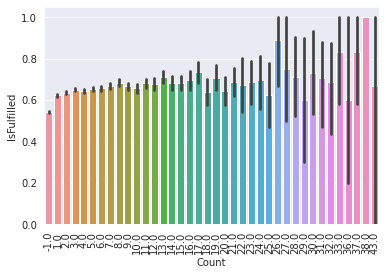

In [6]:
sns.barplot(x='Count',y='IsFulfilled', data=train_df.fillna(-1))
plt.xticks(rotation=90)
plt.show()

In [7]:
for i, df in enumerate([train_df, test_df]):
    
    deneme = pd.merge(answers_df, df[['JobId', 'ServiceId']], on='JobId', how='right')

    for service in [0,1,2]:
        for question in ['Q1','Q2','Q3','Q4']:
            value = deneme[(deneme['Question'] == question)& (deneme['ServiceId'] == service)]

            new_columns = pd.DataFrame()
            new_columns['JobId'] = df.JobId.unique()
            new_columns = pd.merge(new_columns, value, on='JobId', how='left')
            
            if i == 0:
                train_df[str(service)+'_'+question] = new_columns['Answer']
            else:
                test_df[str(service)+'_'+question] = new_columns['Answer']
                
#         if i == 0:
#             train_df[str(service)+'_perc_filled'] = np.sum(~(train_df.loc[:,str(service)+'_Q1':str(service)+'_Q4'].isnull()), axis=1) / 4
#         else:
#             test_df[str(service)+'_perc_filled'] = np.sum(~(test_df.loc[:,str(service)+'_Q1':str(service)+'_Q4'].isnull()), axis=1) / 4

del answers_df

train_df['0_perc_filled'] = np.sum(~(train_df.loc[:,'0_Q1':'0_Q4'].isnull()), axis=1) / 4
test_df['0_perc_filled'] = np.sum(~(test_df.loc[:,'0_Q1':'0_Q4'].isnull()), axis=1) / 4

train_df['1_perc_filled'] = np.sum(~(train_df.loc[:,'1_Q2':'1_Q3'].isnull()), axis=1) / 2
test_df['1_perc_filled'] = np.sum(~(test_df.loc[:,'1_Q2':'1_Q3'].isnull()), axis=1) / 2

for df in [train_df, test_df]:
    df.drop(['1_Q1','1_Q4','2_Q3','2_Q4','2_Q1','2_Q2'], inplace=True, axis=1)
    df.fillna(0, inplace=True)

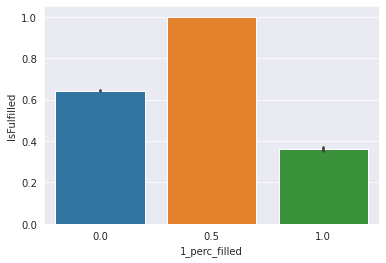

In [8]:
sns.barplot(x='1_perc_filled',y='IsFulfilled', data=train_df)
plt.show()

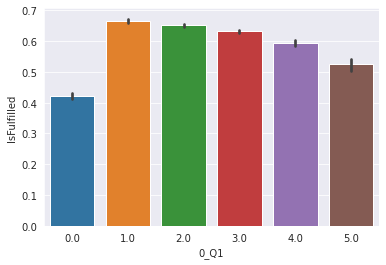

In [9]:
sns.barplot(x='0_Q1',y='IsFulfilled', data=train_df)
plt.show()

In [10]:
train_df['day_interval'] = train_df['JobStartDate'] - train_df['JobCreateDate']
train_df['day_interval'] = (train_df['day_interval'].apply(lambda x: str(x).split(' ')[0])).astype('int')

test_df['day_interval'] = test_df['JobStartDate'] - test_df['JobCreateDate']
test_df['day_interval'] = (test_df['day_interval'].apply(lambda x: str(x).split(' ')[0])).astype('int')

train_df['quarter'] = train_df.JobStartDate.dt.quarter
test_df['quarter'] = test_df.JobStartDate.dt.quarter

for df in [train_df, test_df]:
    df.drop(['JobCreateDate','JobStartDate','UserId'], axis=1, inplace=True)

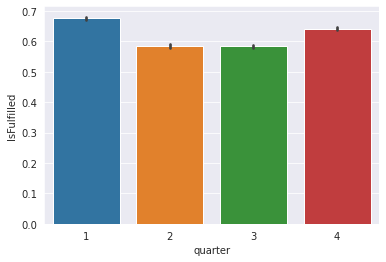

In [11]:
sns.barplot(x='quarter',y='IsFulfilled', data=train_df)
plt.show()

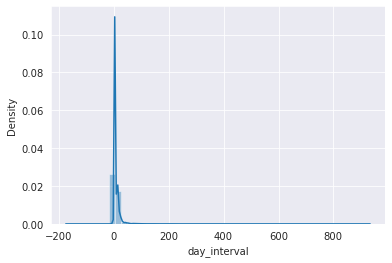

In [12]:
sns.distplot(train_df['day_interval'])
plt.show()

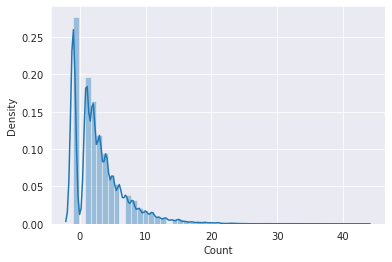

In [13]:
sns.distplot(train_df['Count'])
plt.show()

In [14]:
train_df.drop(train_df[train_df['day_interval'] < 0].index, axis=0, inplace=True)

test_df.loc[test_df['day_interval'] < 0, 'day_interval'] = test_df['day_interval'].median()

train_df['day_interval'] = train_df['day_interval'].apply(lambda x: np.log(x) if x > 0 else 0)
test_df['day_interval'] = test_df['day_interval'].apply(lambda x: np.log(x) if x > 0 else 0)

train_df['Count'] = train_df['Count'].apply(lambda x: np.log(x+1) if x+1 > 0 else 0)
test_df['Count'] = test_df['Count'].apply(lambda x: np.log(x+1) if x+1 > 0 else 0)

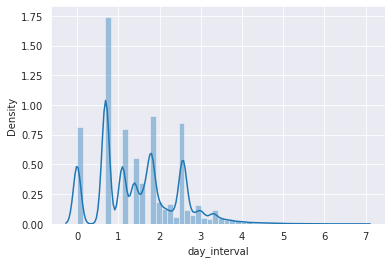

In [15]:
sns.distplot(train_df['day_interval'])
plt.show()

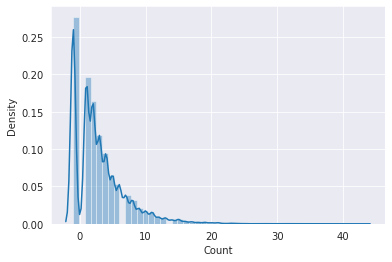

In [16]:
sns.distplot(train_df['Count'])
plt.show()

In [17]:
test_jobids = test_df['JobId']

for df in [train_df, test_df]:
    df.drop('JobId', inplace=True, axis=1)

In [18]:
def create_label_encoding_with_min_count(df, column, min_count=50):
    column_counts = df.groupby([column])[column].transform("count").astype(int)
    column_values = np.where(column_counts >= min_count, df[column], "")

    return column_values

In [19]:
train_df['JobState'] = create_label_encoding_with_min_count(train_df, 'JobState', min_count=200)
train_df['JobCity'] = create_label_encoding_with_min_count(train_df, 'JobCity', min_count=2250)
train_df['JobCity'] = ['' if x == '15' else x for x in train_df['JobCity']]

train_df['JobDistrict'] = create_label_encoding_with_min_count(train_df, 'JobDistrict', min_count=649)
train_df['JobDistrict'] = ['' if ((x == '313') | (x == '101')) else x for x in train_df['JobDistrict']]

test_df['JobState'] = create_label_encoding_with_min_count(test_df, 'JobState', min_count=40)
test_df['JobState'] = ['' if x == '14' else x for x in test_df['JobState']]

test_df['JobCity'] = create_label_encoding_with_min_count(test_df, 'JobCity', min_count=402)
test_df['JobCity'] = ['' if x == '37' else x for x in test_df['JobCity']]

test_df['JobDistrict'] = create_label_encoding_with_min_count(test_df, 'JobDistrict', min_count=120)
test_df['JobDistrict'] = ['' if ((x == '60') | (x == '101')) else x for x in test_df['JobDistrict']]

In [20]:
le = LabelEncoder()
train_df['JobState'] = le.fit_transform(train_df['JobState'])
test_df['JobState'] = le.transform(test_df['JobState'])

le = LabelEncoder()
train_df['JobCity'] = le.fit_transform(train_df['JobCity'])
test_df['JobCity'] = le.transform(test_df['JobCity'])

le = LabelEncoder()
train_df['JobDistrict'] = le.fit_transform(train_df['JobDistrict'])
test_df['JobDistrict'] = le.transform(test_df['JobDistrict'])

In [21]:
model_train = pd.DataFrame()
model_test = pd.DataFrame()

In [22]:
for i, df in enumerate([train_df, test_df]):

    dummies = list()

    dummies.append(pd.get_dummies(df['ServiceId'], prefix='ServiceId'))
    dummies.append(pd.get_dummies(df['JobState'], prefix='JobState'))
    dummies.append(pd.get_dummies(df['JobCity'], prefix='JobCity'))
    dummies.append(pd.get_dummies(df['JobDistrict'], prefix='JobDistrict'))
    dummies.append(pd.get_dummies(df['UserCallPreference'], prefix='UserCallPreference'))
    dummies.append(pd.get_dummies(df['IsRepeat'], prefix='IsRepeat'))
    dummies.append(pd.get_dummies(df['CampaignId'], prefix='CampaignId'))
    dummies.append(pd.get_dummies(df['quarter'], prefix='quarter'))

#     dummies.append(pd.get_dummies(df['0_Q1'], prefix='0_Q1'))
#     dummies.append(pd.get_dummies(df['0_Q2'], prefix='0_Q2'))
#     dummies.append(pd.get_dummies(df['0_Q3'], prefix='0_Q3'))
#     dummies.append(pd.get_dummies(df['0_Q4'], prefix='0_Q4'))
#     dummies.append(pd.get_dummies(df['1_Q2'], prefix='1_Q2'))
#     dummies.append(pd.get_dummies(df['1_Q3'], prefix='1_Q3'))

    dummies.append(df['Price'])
    dummies.append(df['TimeSpent'])
    dummies.append(df['Count'])
    dummies.append(df['0_Q1'])
    dummies.append(df['0_Q2'])
    dummies.append(df['0_Q3'])
    dummies.append(df['0_Q4'])
    dummies.append(df['0_perc_filled'])
    dummies.append(df['1_Q2'])
    dummies.append(df['1_Q3'])
    dummies.append(df['1_perc_filled'])
#     dummies.append(df['2_perc_filled'])
    dummies.append(df['day_interval'])
    
    
    if i == 0:
        dummies.append(df['IsFulfilled'])
        model_train = pd.concat(dummies,axis=1)
    else:
        model_test = pd.concat(dummies,axis=1)
        
# model_train.drop('0_Q3_10.0', axis=1, inplace=True)

del train_df
del test_df
gc.collect()

29055

In [23]:
# len_train = len(model_train)
# model = pd.concat([model_train,model_test], axis=0)

# le = LabelEncoder()
# model['Price'] = le.fit_transform(pd.qcut(model['Price'],6))

# le = LabelEncoder()
# model['TimeSpent'] = le.fit_transform(pd.qcut(model['TimeSpent'],6))

# le = LabelEncoder()
# model['Count'] = le.fit_transform(pd.qcut(model['Count'],4))

# le = LabelEncoder()
# model['day_interval'] = le.fit_transform(pd.qcut(model['day_interval'],5))

# model_train = model[:len_train]
# model_test = model[len_train:]
# del model
# gc.collect()

In [24]:
x_train = model_train.drop('IsFulfilled', axis=1)
y_train = model_train['IsFulfilled']

x_test = model_test

del model_train; del model_test; gc.collect()

40

In [25]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score, f1_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold, learning_curve, cross_validate, RepeatedStratifiedKFold
from sklearn.naive_bayes import GaussianNB

from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

In [26]:
#!pip install imblearn

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours
from sklearn.utils import shuffle
from imblearn.under_sampling import TomekLinks

In [ ]:
Counter(y_train)

In [32]:
# ous = RandomUnderSampler(random_state=14)
# x_res,y_res = ous.fit_resample(x_train, y_train)

nm = NearMiss()
x_res,y_res = nm.fit_resample(x_train, y_train)

# smk = SMOTETomek(random_state=14)
# x_res, y_res = smk.fit_resample(x_t, y_t)

x_t, x_v, y_t, y_v = train_test_split(x_res, y_res,
                                      test_size = .33,
                                      random_state=14,
                                      #stratify=y_train
                                     )

In [ ]:
x_t, x_v, y_t, y_v = train_test_split(x_res, y_res,
                                      test_size = .33,
                                      random_state=14,
                                      #stratify=y_train
                                     )

ovs = RandomOverSampler(random_state=14)
x_res2, y_res2 = ovs.fit_resample(x_t, y_t)

In [28]:
def xgb_f1(y, t, threshold=0.5):
    t = t.get_label()
    y_bin = (y > threshold).astype(int)
    return 'f1',f1_score(t,y_bin)

In [39]:
best_params = {'updater': ['grow_gpu_hist'],
 'tree_method': ['gpu_hist'],
 'subsample': [0.6],
 'predictor': ['gpu_predictor'],
 'n_estimators': [1000],
 'min_child_weight': [3],
 'max_depth': [8],
 'learning_rate': [0.03],
 'gamma': [0.5],
 'colsample_bytree': [1.0]}


params = {
        'min_child_weight': [2,3,4,5, 10, 15],
        'gamma': [0.5, 1, 1.5, 2, 3.5, 5],
        'subsample': [0.4, 0.6,0.7, 0.8, 1.0],
        'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 8,10,12,15],
        'n_estimators': [400,600,800,1000,1200,1600,2000,2500],
        'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.5, 1, 1.5]
        }

params['tree_method'] = ['gpu_hist']
params['updater'] = ['grow_gpu_hist']
params['predictor'] = ['gpu_predictor']

# class_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])
# scale_post_weight=class_weight
xgb = XGBClassifier(objective='binary:logistic',
                    silent=True, nthread=1,eval_metric=xgb_f1,verbosity=0, booster='gbtree')

folds = 3
param_comb = 100
SEED = 144

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = SEED)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='f1_macro', n_jobs=-1, cv=skf.split(x_t, y_t), verbose=3, random_state=SEED)

random_search.fit(x_t, y_t)
print('OK')

Fitting 3 folds for each of 100 candidates, totalling 300 fits
OK


In [40]:
print(random_search.cv_results_['split0_test_score'])
print(random_search.cv_results_['split1_test_score'])
print(random_search.cv_results_['split2_test_score'])
print(random_search.cv_results_['mean_test_score'])
print(random_search.cv_results_['std_test_score'])
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)

[0.67935344 0.61186358 0.68611693 0.69093501 0.67556385 0.61860174
 0.61145053 0.69256452 0.62386315 0.68020497 0.62634829 0.62347653
 0.68608633 0.63559259 0.64542263 0.6908521  0.68668091 0.66210441
 0.68566694 0.68332527 0.60716728 0.68664669 0.68898265 0.69257059
 0.68308207 0.66779261 0.67159734 0.69015909 0.69105168 0.68303918
 0.67684089 0.64967497 0.68646631 0.66229768 0.69115195 0.66787925
 0.68135193 0.62113852 0.68553267 0.60697656 0.62289787 0.68276951
 0.68770981 0.68716621 0.6883945  0.64860141 0.67076075 0.67663391
 0.62182353 0.6888234  0.68829675 0.64383645 0.68755902 0.67947624
 0.62310942 0.68676854 0.68068554 0.68377285 0.67542203 0.69132625
 0.68849199 0.68559421 0.66354342 0.68968764 0.64604535 0.68229422
 0.68846384 0.68848308 0.62269459 0.66621402 0.68884345 0.69163788
 0.62664007 0.68469161 0.6439198  0.68673727 0.6846852  0.68939306
 0.59864286 0.65530736 0.63011294 0.68820683 0.68797976 0.61373519
 0.6795254  0.68759121 0.60368673 0.68294389 0.68210792 0.6249

In [41]:
preds = random_search.predict(x_v)
print(classification_report(y_v, preds))
print(confusion_matrix(y_v, preds))
print(Counter(random_search.predict(x_test)))

              precision    recall  f1-score   support

           0       0.74      0.60      0.66     16933
           1       0.66      0.79      0.72     17040

    accuracy                           0.69     33973
   macro avg       0.70      0.69      0.69     33973
weighted avg       0.70      0.69      0.69     33973

[[10122  6811]
 [ 3622 13418]]
Counter({1: 12447, 0: 11588})


In [ ]:
sub = pd.DataFrame()

sub['JobId'] = test_jobids
sub['IsFulfilled'] = random_search.predict(x_test)

sub.to_csv('xgb_69f1.csv', index=False)

In [ ]:
# best_params = {'updater': ['grow_gpu_hist'],
#  'tree_method': ['gpu_hist'],
#  'subsample': [0.6],
#  'predictor': ['gpu_predictor'],
#  'n_estimators': [1000],
#  'min_child_weight': [3],
#  'max_depth': [8],
#  'learning_rate': [0.03],
#  'gamma': [0.5],
#  'colsample_bytree': [1.0]}

# nearmiss
# folds = 3
# param_comb = 1
# SEED = 14
#  precision    recall  f1-score   support

#            0       0.73      0.61      0.66     16933
#            1       0.67      0.78      0.72     17040

#     accuracy                           0.69     33973
#    macro avg       0.70      0.69      0.69     33973
# weighted avg       0.70      0.69      0.69     33973

# [[10280  6653]
#  [ 3783 13257]]
# Counter({1: 12360, 0: 11675})